In [ ]:
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import scipy as sp
import scipy.ndimage
from cyclic_gps.models import LEGFamily
from cyclic_gps.data_utils import time_series_dataloader
import matplotlib.pyplot as plt

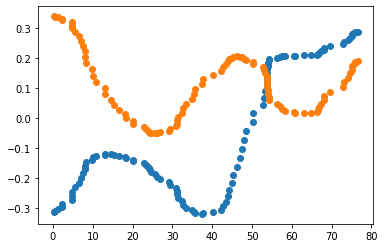

In [2]:
num_datapoints = 100
sample1_ts = torch.empty(num_datapoints)
sample1_ts = torch.cumsum(sample1_ts.exponential_(lambd=1) + 0.01, dim=0)
sample1_vals = torch.tensor(
    sp.ndimage.gaussian_filter1d(torch.randn(num_datapoints), 10, axis=0)[:, None]
)
sample2_vals = torch.tensor(
    sp.ndimage.gaussian_filter1d(torch.randn(num_datapoints), 10, axis=0)[:, None]
)
vals = torch.cat([sample1_vals, sample2_vals], dim=-1)

assert vals.shape == (num_datapoints, 2)
assert sample1_ts.shape == (num_datapoints,)

plt.scatter(sample1_ts, vals[:, 0])
plt.scatter(sample1_ts, vals[:, 1])

In [3]:
# generate torch dataset
dataset = time_series_dataloader(sample1_ts.unsqueeze(0), vals.unsqueeze(0))
example = dataset[0]
assert torch.allclose(example[0], sample1_ts.unsqueeze(0)) # we're getting our data plus one batch element
dl = DataLoader(dataset=dataset, batch_size=1)


In [5]:
RANK = 5
MAX_EPOCHS = 1000
LEG_model = LEGFamily(rank=RANK, obs_dim=vals.shape[1], train=True)

In [5]:
#plt.imshow(LEG_model.N.detach().numpy())

In [6]:
logger = pl.loggers.TensorBoardLogger("tb_logs", name="first_pass_model")
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, logger=logger, log_every_n_steps=1)
trainer.fit(model=LEG_model, train_dataloaders=dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type | Params
------------------------------
------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
/Users/danbiderman/miniconda3/envs/cyclic-gps/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, loss=-1.04, v_num=8]         

/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/cyclic-gps/cyclic_gps/cyclic_reduction.py:241: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  torch.triangular_solve(input=Os_even_T, A=Ks_even[:N2], upper=False)[0], 1, 2


Epoch 452:   0%|          | 0/1 [00:00<?, ?it/s, loss=-7.82, v_num=8]        

/Users/danbiderman/miniconda3/envs/cyclic-gps/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/danbiderman/miniconda3/envs/cyclic-gps/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/danbiderman/miniconda3/envs/cyclic-gps/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.

### Posterior Inference test
1. simulate data from a LEG process
2. do standard inference.
3. plot and show that they match.
4. later, do posterior predictive.